### Estimativa de Prognóstico de Geração

Desenvolvam um modelo preditivo capaz de estimar a geração futura
de uma usina com potência xxx e localização yyy, considerando a
geração histórica de usinas vizinhas. Esse modelo poderá auxiliar em
planejamentos de expansão e manutenção preventiva das usinas.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
df_unidade_consumidora = pd.read_csv('./datasets/unidade_consumidora')
df_geracao = pd.read_csv('./datasets/geracao', chunksize=1000000)
df_usina = pd.read_csv('./datasets/usina')
df_cidade = pd.read_csv('./datasets/cidade')
df_endereco = pd.read_csv('./datasets/endereco')
df_estado = pd.read_csv('./datasets/estado')
df_id_ext = pd.read_csv('./datasets/id_ext')
df_usina_historico = pd.read_csv('./datasets/usina_historico')

In [14]:
# Removendo os dados ausentes da coluna potencia
df_usina.dropna(subset=['potencia'], inplace=True)

# Removendo a coluna last_plant_history_id
df_usina.drop(columns=['last_plant_history_id'], inplace=True)

In [16]:
# Selecionando 100000 dados de amostra
df_usina_amostra = df_usina.sample(n=20000, random_state=42)

# IDs usinas
ids_usinas_amostra = df_usina_amostra['id'].tolist()

In [17]:
geracao_filtrada = []

for chunk in df_geracao:
    # Filtrar dados de geracao das usinas amostra
    chunk_filtrado = chunk[chunk['id_usina'].isin(ids_usinas_amostra)]

    # Adicionar o chunk filtrado à lista
    geracao_filtrada.append(chunk_filtrado)

# Concatenar todos os chunks filtrados em um único DataFrame
df_geracao_filtrada = pd.concat(geracao_filtrada, ignore_index=True)

In [18]:
df_geracao_filtrada.dropna(subset=['quantidade', 'prognostico'], inplace=True)

### Tratamento de dados

In [19]:
df_cidade.rename(columns={'nome': 'nome_cidade'}, inplace=True, errors='ignore')
df_cidade.drop(columns=['created_at'], inplace=True, errors='ignore')

df_usina_historico.drop(columns=['performance_type_enum'], inplace=True, errors='ignore')
df_usina_historico.dropna(subset=['performance'], inplace=True)

df_unidade_consumidora.dropna(subset=['id_endereco'], inplace=True)

df_endereco.dropna(subset=['id_cidade'], inplace=True)

### Merge tabelas

In [20]:
# Unir usina com unidade_consumidora
df = df_usina_amostra.merge(df_unidade_consumidora, left_on='unidade_consumidora_id', right_on='id', how='inner', suffixes=('', '_unidade_consumidora'))
df.drop(columns=['id_unidade_consumidora'], inplace=True)

# Unir unidade_consumidora com endereço
df = df.merge(df_endereco, left_on='id_endereco', right_on='id', how='inner', suffixes=('', '_endereco_2'))
df.drop(columns=['id_endereco_2'], inplace=True)
df['id_endereco'] = df['id_endereco'].astype(int)

# Unir endereço com cidade
df = df.merge(df_cidade, left_on='id_cidade', right_on='id', how='inner', suffixes=('', '_cidade_2'))
df.drop(columns=['id_cidade_2'], inplace=True)
df['id_cidade'] = df['id_cidade'].astype(int)

# Unir cidade com estado
df = df.merge(df_estado, left_on='id_estado', right_on='id', how='inner', suffixes=('', '_estado_2'))
df.drop(columns=['id_estado_2'], inplace=True)

# Unir usina com usina_historico para obter potência histórica
df = df.merge(df_usina_historico, left_on='id', right_on='plant_id', how='inner', suffixes=('', '_usina_historico'))
df.drop(columns=['plant_id'], inplace=True)

# Unir geracao com df
df = pd.merge(df_geracao_filtrada, df, left_on='id_usina', right_on='id', how='inner', suffixes=('', '_geracao'))
df.drop(columns=['id_geracao'], inplace=True)

df.head()

,id,data,prognostico,quantidade,id_usina,potencia,unidade_consumidora_id,id_endereco,id_cidade,nome_cidade,id_estado,denominacao,uf,regiao,id_usina_historico,power,performance,start_date
0,3141723,2020-08-24,14.21,0.00,8667,3.780,9256,5720,630,Santo Antônio de Jesus,5,Bahia,BA,Nordeste,42262,3.780,1612.00,2020-04-19 03:00:00
1,3141835,2020-08-24,34.07,22.12,14784,9.520,16243,41158,616,Salvador,5,Bahia,BA,Nordeste,66328,9.520,1495.00,2020-02-01 03:00:00
2,33658,2019-08-25,32.77,45.80,155,10.880,249,1041,4173,Portão,21,Rio Grande do Sul,RS,Sul,41796,10.880,1375.32,2019-05-20 03:00:00
3,3142359,2020-08-24,13.01,8.97,13091,3.795,14107,10445,122,Teofilo Otoni,13,Minas Gerais,MG,Sudeste,60932,3.795,1384.00,2020-06-22 13:16:03.137
4,3141722,2020-08-24,105.34,81.40,12224,28.860,13128,8948,1696,Cantagalo,13,Minas Gerais,MG,Sudeste,59924,28.860,1460.00,2020-02-06 03:00:00


In [30]:
desafio_2_df = df[['potencia', 'quantidade', 'id_cidade']]
desafio_2_df.groupby(['id_cidade']).mean()

# Filtrando outliers
desafio_2_df = desafio_2_df[desafio_2_df['id_cidade'] < 6000]
desafio_2_df = desafio_2_df[desafio_2_df['potencia'] < 200]

X = desafio_2_df[["id_cidade", 'potencia']]
y = desafio_2_df["quantidade"]

# Divisão de dados: treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Previsões com o conjunto de teste
y_pred = regressor.predict(X_test)

a = regressor.coef_
b = regressor.intercept_ 

print(f"Equação da reta: y = {a[0]:.2f} * id_cidade + {a[1]:.2f} * potencia + {b:.2f}")

r2_score = regressor.score(X_test, y_test)
print(f"R²: {r2_score:.2f}")

Equação da reta: y = -0.00 * id_cidade + 3.17 * potencia + 4.16
R²: 0.51


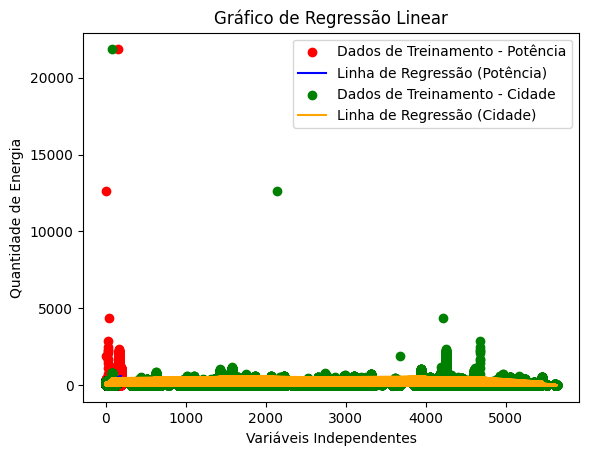

In [27]:
# Relação entre 'potencia' e 'quantidade'
plt.scatter(X_test['potencia'], y_test, color='red', label='Dados de Treinamento - Potência')

# Predição para a 'potencia'
plt.plot(X_test['potencia'], regressor.predict(X_test), color='blue', label='Linha de Regressão (Potência)')

# Visualizando a relação entre 'id_cidade' e 'quantidade'
plt.scatter(X_test['id_cidade'], y_test, color='green', label='Dados de Treinamento - Cidade')

# Predição para o 'id_cidade'
plt.plot(X_test['id_cidade'], regressor.predict(X_test), color='orange', label='Linha de Regressão (Cidade)')

plt.title('Gráfico de Regressão Linear')
plt.xlabel('Variáveis Independentes')
plt.ylabel('Quantidade de Energia')
plt.legend()

plt.show()

In [ ]:
desafio_2_df = df[['potencia', 'quantidade', 'id_cidade']]
desafio_2_df = desafio_2_df[desafio_2_df['id_cidade'] < 6000]
desafio_2_df = desafio_2_df[desafio_2_df['potencia'] < 200]

X = desafio_2_df[["id_cidade", "potencia"]]
y = desafio_2_df["quantidade"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(
    n_estimators=100,        
    max_depth=None,          
    random_state=42,
    n_jobs=-1
)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

MSE: 5315.15
R²: 0.59


In [ ]:
y_test_pred = rf_regressor.predict(X_test)

results = X_test.copy()
results['Quantidade Real'] = y_test
results['Quantidade Prevista'] = y_test_pred

print(results.head())

         id_cidade  potencia  Quantidade Real  Quantidade Prevista
349569        3658      7.92           20.000            16.304755
974372        4449     68.40          186.144           185.966393
1011419       4267      7.70           21.820            10.561911
1221993       4571      4.14            9.900            12.478966
170965        1625      8.20           44.867            43.047590


In [38]:
id_cidade = 630
potencia = 3.780
rf_regressor.predict([[id_cidade, potencia]])

/home/talismar/Desktop/hackatom/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([0.33057611])